In [31]:
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt


def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


def plot_chart_and_predict(model, X_test, X_train, y_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previsto')
    plt.title('Gráfico de Dispersão: Valores Reais vs Valores Previsto')
    plt.show()
    
    # Erros
    print("Erro Absoluto Médio (MAE):", mean_absolute_error(y_test, y_pred))
    print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, y_pred))
    print("Raiz do Erro Quadrático Médio (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAPE:", calculate_mape(y_test, y_pred), "%")
    print("R²:", r2_score(y_test, y_pred))



data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo

data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"


# Preparando os dados
numeric_columns = [ 'age', 'bmi', 'children'] # Colunas numéricas
categorical_columns = [ 'smoker', 'weight_condition']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns), # numeric features
        ('cat', OneHotEncoder(), categorical_columns) # categorical features
    ])
base_transformed = preprocessor.fit_transform(data)
base_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
data = pd.concat([data['charges'], base_transformed_df], axis=1)
data.head()



,charges,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,16884.92400,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
1,1725.55230,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
2,4449.46200,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
3,21984.47061,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
4,3866.85520,-0.513149,-0.292556,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0


In [32]:
data.isnull().sum()

charges                                0
num__age                               0
num__bmi                               0
num__children                          0
cat__smoker_no                         0
cat__smoker_yes                        0
cat__weight_condition_Normal Weight    0
cat__weight_condition_Obese            0
cat__weight_condition_Overweight       0
cat__weight_condition_Underweight      0
dtype: int64

charges                                1.000000
cat__smoker_yes                        0.787251
num__age                               0.299008
cat__weight_condition_Obese            0.199532
num__bmi                               0.198341
num__children                          0.067998
cat__weight_condition_Underweight     -0.044960
cat__weight_condition_Normal Weight   -0.106265
cat__weight_condition_Overweight      -0.120083
cat__smoker_no                        -0.787251
Name: charges, dtype: float64


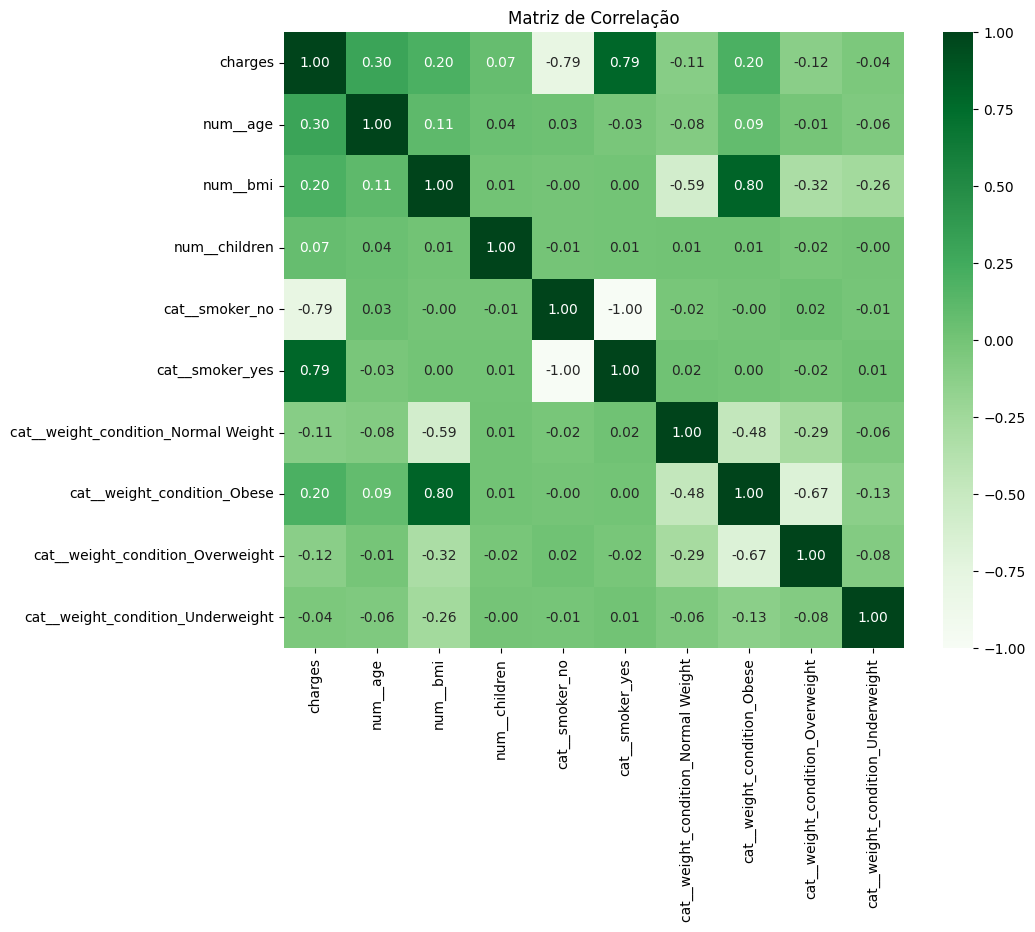

In [33]:
# Matriz de correlação
correlation_matrix = data.corr()
print(correlation_matrix["charges"].sort_values(ascending=False))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [34]:
X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



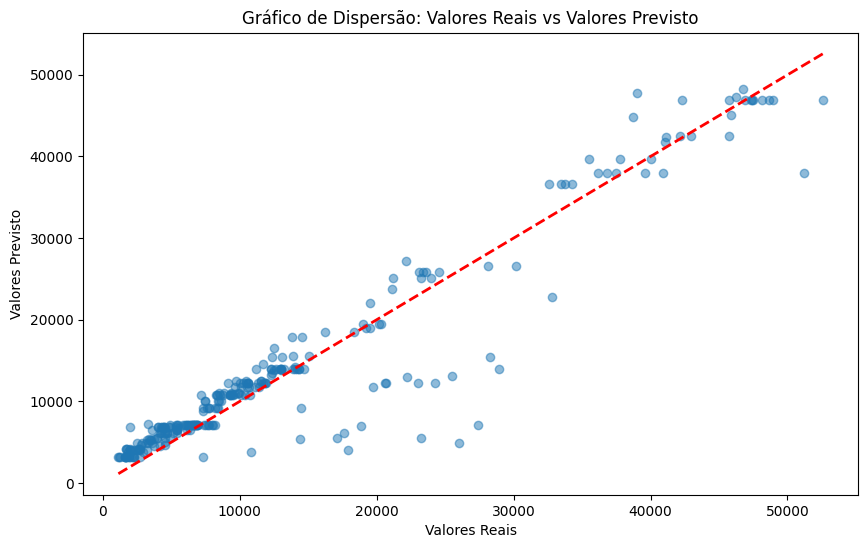

Erro Absoluto Médio (MAE): 2393.7231158087056
Erro Quadrático Médio (MSE): 15811264.726478495
Raiz do Erro Quadrático Médio (RMSE): 3976.3381051513334
MAPE: 30.37086731377442 %
R²: 0.9006392982455946


In [35]:
model = RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1)
plot_chart_and_predict(model, X_test, X_train, y_test, y_train)

In [36]:
import eli5
# 
colunas = preprocessor.get_feature_names_out()
eli5.show_weights(model, feature_names = colunas)


Weight,Feature
0.4869 ± 0.6175,cat__smoker_yes
0.1899 ± 0.6004,cat__smoker_no
0.1892 ± 0.0286,num__bmi
0.1247 ± 0.0211,num__age
0.0091 ± 0.0055,num__children
0.0003 ± 0.0013,cat__weight_condition_Overweight
0 ± 0.0000,cat__weight_condition_Underweight
0 ± 0.0000,cat__weight_condition_Normal Weight
0 ± 0.0000,cat__weight_condition_Obese


In [37]:

from eli5 import show_prediction
from sklearn.calibration import LabelEncoder

previsores = data.iloc[:, :-1].values
labelencoder = LabelEncoder()
for i in range(previsores.shape[1]):
  if previsores[:,i].dtype == 'object':
    previsores[:,i] = labelencoder.fit_transform( previsores[:,i])
    
eli5.show_prediction(model, previsores[1], feature_names = colunas, show_feature_values=True)

/home/lucas/Study/projects/IA-Studies/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class WeightConditionTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["weight_condition"] = ""
        X.loc[X["bmi"] < 18.5, "weight_condition"] = "Underweight"
        X.loc[(X["bmi"] >= 18.5) & (X["bmi"] < 25), "weight_condition"] = "Normal Weight"
        X.loc[(X["bmi"] >= 25) & (X["bmi"] < 30), "weight_condition"] = "Overweight"
        X.loc[X["bmi"] >= 30, "weight_condition"] = "Obese"
        #X = X.drop(['bmi'], axis='columns') 
        return X

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age', 'bmi', 'children']), # numeric features
    ('cat', OneHotEncoder(), ['smoker', "weight_condition"]) # categorical features
])

pipeline = Pipeline(steps=[
    ('add_weight_condition', WeightConditionTransformer()), # Adiciona a coluna weight_condition
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=7, max_depth=30, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1))
])

data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo


X = data.drop(['charges'], axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
pipeline.fit(X_train, y_train)

with open('wcmodel.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
    
pipeline


Pipeline(steps=[('add_weight_condition', WeightConditionTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['smoker',
                                                   'weight_condition'])])),
                ('model',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=30,
                                       max_leaf_nodes=17, n_estimators=7,
                                       random_state=1))])

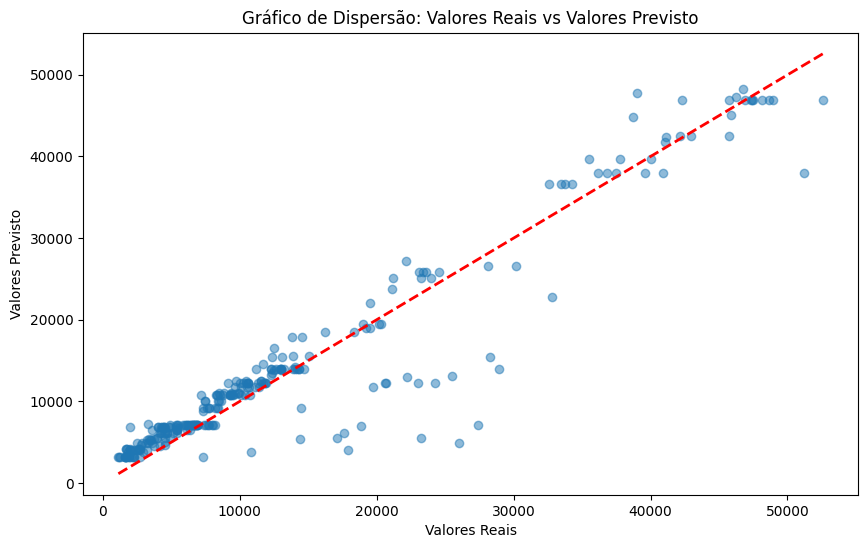

Erro Absoluto Médio (MAE): 2393.7231158087056
Erro Quadrático Médio (MSE): 15811264.726478495
Raiz do Erro Quadrático Médio (RMSE): 3976.3381051513334
MAPE: 30.37086731377442 %
R²: 0.9006392982455946


In [39]:
plot_chart_and_predict(pipeline, X_test, X_train, y_test, y_train)

In [40]:
from pydantic import BaseModel


class InsuranceData(BaseModel):
    smoker: str
    age: int
    bmi: float
    children: int
    

class WealthCostPrediction:
    
    def __init__(self):
        self.model_path = 'wcmodel.pkl'
        self.pipeline = None
        
    def predict(self, features):
        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"Model file '{self.model_path}' not found. Please train the model first.")
        
        with open(self.model_path, 'rb') as f:
            self.pipeline = pickle.load(f)
        
        if not isinstance(features, pd.DataFrame):
            features = pd.DataFrame([features], columns=['smoker', 'age', 'bmi', 'children'])
        
        prediction = self.pipeline.predict(features)
        return round(float(prediction[0]), 2)
        


features = InsuranceData(smoker='no', age=33, bmi=25, children=0)


prediction = WealthCostPrediction()
result = prediction.predict([features.smoker, features.age, features.bmi, features.children])
print(f"Predicted insurance cost: {result}")


Predicted insurance cost: 6172.02
